# Illustrate effect of boundary-unware filters

In [1]:
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy

In [3]:
import gcm_filters

In [4]:
list(gcm_filters.GridType)

[<GridType.REGULAR: 1>,
 <GridType.REGULAR_WITH_LAND: 2>,
 <GridType.IRREGULAR_WITH_LAND: 3>,
 <GridType.TRIPOLAR_REGULAR_WITH_LAND: 4>,
 <GridType.TRIPOLAR_POP_WITH_LAND: 5>,
 <GridType.VECTOR_C_GRID: 6>]

## Open 0.1 degree MOM6 data

In [7]:
ds = xr.open_dataset('/glade/scratch/gmarques/for_nora/g.c2b6.GJRA.TL319_t13.control_mct.003.mom6.sfc_0022_01.nc', decode_times=False)
ds

<xarray.Dataset>
Dimensions:       (nv: 2, time: 31, xh: 3600, xq: 3600, yh: 2400, yq: 2400)
Coordinates:
  * xh            (xh) float64 -109.9 -109.8 -109.8 ... -110.2 -110.2 -110.1
  * yh            (yh) float64 -78.47 -78.43 -78.39 -78.35 ... 89.88 89.92 89.97
  * time          (time) float64 7.666e+03 7.666e+03 ... 7.694e+03 7.696e+03
  * nv            (nv) float64 1.0 2.0
  * xq            (xq) float64 -109.9 -109.8 -109.7 ... -110.2 -110.1 -110.0
  * yq            (yq) float64 -78.45 -78.41 -78.37 -78.32 ... 89.9 89.95 90.0
Data variables:
    SSH           (time, yh, xh) float32 ...
    tos           (time, yh, xh) float32 ...
    sos           (time, yh, xh) float32 ...
    SSU           (time, yh, xq) float32 ...
    SSV           (time, yq, xh) float32 ...
    mass_wt       (time, yh, xh) float32 ...
    opottempmint  (time, yh, xh) float32 ...
    somint        (time, yh, xh) float32 ...
    Rd_dx         (time, yh, xh) float32 ...
    speed         (time, yh, xh) float32 ...
    mlotst        (time, yh, xh) float32 ...
    oml           (time, yh, xh) float32 ...
    average_T1    (time) float64 ...
    average_T2    (time) float64 ...
    average_DT    (time) float64 ...
    time_bnds     (time, nv) float64 ...
Attributes:
    filename:          combined/g.c2b6.GJRA.TL319_t13.control_mct.003.mom6.sf...
    title:             MOM6 diagnostic fields table for CESM case: g.c2b6.GJR...
    associated_files:  area_t: g.c2b6.GJRA.TL319_t13.control_mct.003.mom6.sta...
    grid_type:         regular
    grid_tile:         N/A
    history:           20201204T1851Z: mppnccombine-fast --output combined/g....

In [8]:
ds_static = xr.open_dataset('/glade/scratch/gmarques/for_nora/g.c2b6.GJRA.TL319_t13.control_mct.003.mom6.static.nc', decode_times=False)
ds_static

<xarray.Dataset>
Dimensions:      (time: 1, xh: 3600, xq: 3600, yh: 2400, yq: 2400)
Coordinates:
  * xh           (xh) float64 -109.9 -109.8 -109.8 ... -110.2 -110.2 -110.1
  * yh           (yh) float64 -78.47 -78.43 -78.39 -78.35 ... 89.88 89.92 89.97
  * time         (time) float64 0.0
  * xq           (xq) float64 -109.9 -109.8 -109.7 ... -110.2 -110.1 -110.0
  * yq           (yq) float64 -78.45 -78.41 -78.37 -78.32 ... 89.9 89.95 90.0
Data variables:
    geolon       (yh, xh) float32 ...
    geolat       (yh, xh) float32 ...
    geolon_c     (yq, xq) float32 ...
    geolat_c     (yq, xq) float32 ...
    geolon_u     (yh, xq) float32 ...
    geolat_u     (yh, xq) float32 ...
    geolon_v     (yq, xh) float32 ...
    geolat_v     (yq, xh) float32 ...
    dyCu         (yh, xq) float32 ...
    dxCv         (yq, xh) float32 ...
    dxCu         (yh, xq) float32 ...
    dyCv         (yq, xh) float32 ...
    area_t       (yh, xh) float32 ...
    depth_ocean  (yh, xh) float32 ...
    wet          (yh, xh) float32 ...
    wet_c        (yq, xq) float32 ...
    wet_u        (yh, xq) float32 ...
    wet_v        (yq, xh) float32 ...
    Coriolis     (yq, xq) float32 ...
Attributes:
    filename:   combined/g.c2b6.GJRA.TL319_t13.control_mct.003.mom6.static.nc
    title:      MOM6 diagnostic fields table for CESM case: g.c2b6.GJRA.TL319...
    grid_type:  regular
    grid_tile:  N/A
    history:    20210528T1522Z: mppnccombine-fast --output combined/g.c2b6.GJ...

### Preparing the grid info

In [16]:
from xgcm import Grid
coords = {'X': {'center': 'xh', 'right': 'xq'},
            'Y': {'center': 'yh', 'right': 'yq'}
         }
grid = Grid(ds_static, coords=coords, periodic=['X']) 

In [18]:
ds_static['dxT'] = grid.interp(ds_static.dxCu,'X')
ds_static['dyT'] = grid.interp(ds_static.dyCv,'Y',boundary='fill')
ds_static['dxBu'] = grid.interp(ds_static.dxCv,'X')
ds_static['dyBu'] = grid.interp(ds_static.dyCu,'Y',boundary='fill')

In [199]:
# grid info centered at T-points
wet_mask_t = ds_static.wet
dxT = ds_static.dxT
dyT = ds_static.dyT
# grid info centered at U-points
dxCu = ds_static.dxCu
dyCu = ds_static.dyCu
area_u = dxCu * dyCu
# grid info centered at V-points
dxCv = ds_static.dxCv
dyCv = ds_static.dyCv
area_v = dxCv * dyCv
# grid info centered at vorticity points
wet_mask_q = ds_static.wet_c
dxBu = ds_static.dxBu
dyBu = ds_static.dyBu

In [201]:
dxCu = dxCu.swap_dims({"xq": "xh"})
dyCu = dyCu.swap_dims({"xq": "xh"})
area_u = area_u.swap_dims({"xq": "xh"})

dxCv = dxCv.swap_dims({"yq": "yh"})
dyCv = dyCv.swap_dims({"yq": "yh"})
area_v = area_v.swap_dims({"yq": "yh"})

wet_mask_q = wet_mask_q.swap_dims({"xq": "xh", "yq": "yh"})
dxBu = dxBu.swap_dims({"xq": "xh", "yq": "yh"})
dyBu = dyBu.swap_dims({"xq": "xh", "yq": "yh"})

In [204]:
dx_min = min(dxT.where(wet_mask_t).min(), dyT.where(wet_mask_t).min())
dx_min = dx_min.values
dx_min

array(2245.78271484)

## Define spatial filters

In [258]:
filter_scale = 1000000

In [259]:
kappa_iso = xr.ones_like(dxT)
kappa_aniso = xr.zeros_like(dyT)

In [260]:
filter_visc = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=dx_min,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.VECTOR_C_GRID,
    grid_vars={
        'wet_mask_t': wet_mask_t, 'wet_mask_q': wet_mask_q,
        'dxT': dxT, 'dyT': dyT, 
        'dxCu': dxCu, 'dyCu': dyCu, 'area_u': area_u, 
        'dxCv': dxCv, 'dyCv': dyCv, 'area_v': area_v,
        'dxBu': dxBu, 'dyBu': dyBu,
        'kappa_iso': kappa_iso, 'kappa_aniso': kappa_aniso
    }
)
filter_visc

/glade/u/home/noraloose/gcm-filters/gcm_filters/filter.py:313: UserWarning: Warning: Filter scale much larger than grid scale -> numerical instability possible
  UserWarning,


Filter(filter_scale=1000000, dx_min=array(2245.78271484), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=490, grid_type=<GridType.VECTOR_C_GRID: 6>)

In [261]:
filter_visc_boundary_unaware = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=dx_min,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.VECTOR_C_GRID,
    grid_vars={
        'wet_mask_t': xr.ones_like(dxT), 'wet_mask_q': xr.ones_like(dxBu),
        'dxT': dxT, 'dyT': dyT, 
        'dxCu': dxCu, 'dyCu': dyCu, 'area_u': area_u, 
        'dxCv': dxCv, 'dyCv': dyCv, 'area_v': area_v,
        'dxBu': dxBu, 'dyBu': dyBu,
        'kappa_iso': kappa_iso, 'kappa_aniso': kappa_aniso
    }
)
filter_visc_boundary_unaware

/glade/u/home/noraloose/gcm-filters/gcm_filters/filter.py:313: UserWarning: Warning: Filter scale much larger than grid scale -> numerical instability possible
  UserWarning,


Filter(filter_scale=1000000, dx_min=array(2245.78271484), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=490, grid_type=<GridType.VECTOR_C_GRID: 6>)

In [262]:
u = ds['SSU'].isel(time=0).where(ds_static.wet_u).compute()
v = ds['SSV'].isel(time=0).where(ds_static.wet_v).compute()

In [263]:
ds_tmp = xr.Dataset()  # temporary dataset with renamed dimensions
ds_tmp['u'] = ds['SSU'].isel(time=0).compute()
ds_tmp['v'] = ds['SSV'].isel(time=0).compute()
ds_tmp

<xarray.Dataset>
Dimensions:  (xh: 3600, xq: 3600, yh: 2400, yq: 2400)
Coordinates:
  * yh       (yh) float64 -78.47 -78.43 -78.39 -78.35 ... 89.88 89.92 89.97
    time     float64 7.666e+03
  * xq       (xq) float64 -109.9 -109.8 -109.7 -109.6 ... -110.2 -110.1 -110.0
  * xh       (xh) float64 -109.9 -109.8 -109.8 -109.7 ... -110.2 -110.2 -110.1
  * yq       (yq) float64 -78.45 -78.41 -78.37 -78.32 ... 89.85 89.9 89.95 90.0
Data variables:
    u        (yh, xq) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    v        (yq, xh) float32 nan nan nan nan nan nan ... nan nan nan nan nan

In [264]:
ds_tmp['u'] = ds_tmp['u'].swap_dims({'xq':'xh'})
ds_tmp['v'] = ds_tmp['v'].swap_dims({'yq':'yh'})

In [265]:
(u_filtered, v_filtered) = filter_visc_100km.apply_to_vector(ds_tmp.u, ds_tmp.v, dims=['yh', 'xh'])

In [266]:
(u_filtered_unaware, v_filtered_unaware) = filter_visc_100km_boundary_unaware.apply_to_vector(ds_tmp.u.fillna(value=0), ds_tmp.v.fillna(value=0), dims=['yh', 'xh'])

In [267]:
ds_tmp['u_filtered'] = u_filtered.compute()
ds_tmp['v_filtered'] = v_filtered.compute()
ds_tmp['u_filtered_unaware'] = u_filtered_unaware.compute()
ds_tmp['v_filtered_unaware'] = v_filtered_unaware.compute()
ds_tmp['u_filtered'] = ds_tmp['u_filtered'].swap_dims({'xh':'xq'})
ds_tmp['v_filtered'] = ds_tmp['v_filtered'].swap_dims({'yh':'yq'})
ds_tmp['u_filtered_unaware'] = ds_tmp['u_filtered_unaware'].swap_dims({'xh':'xq'})
ds_tmp['v_filtered_unaware'] = ds_tmp['v_filtered_unaware'].swap_dims({'yh':'yq'})

In [253]:
from matplotlib import cm
cmap = cm.get_cmap('RdBu_r')
cmap.set_bad(color='0.8', alpha=0.5) 

cmap2 = cm.get_cmap('BrBG')
cmap2.set_bad(color='0.8', alpha=0.5) 

In [271]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'font.size': 12}
pylab.rcParams.update(params)

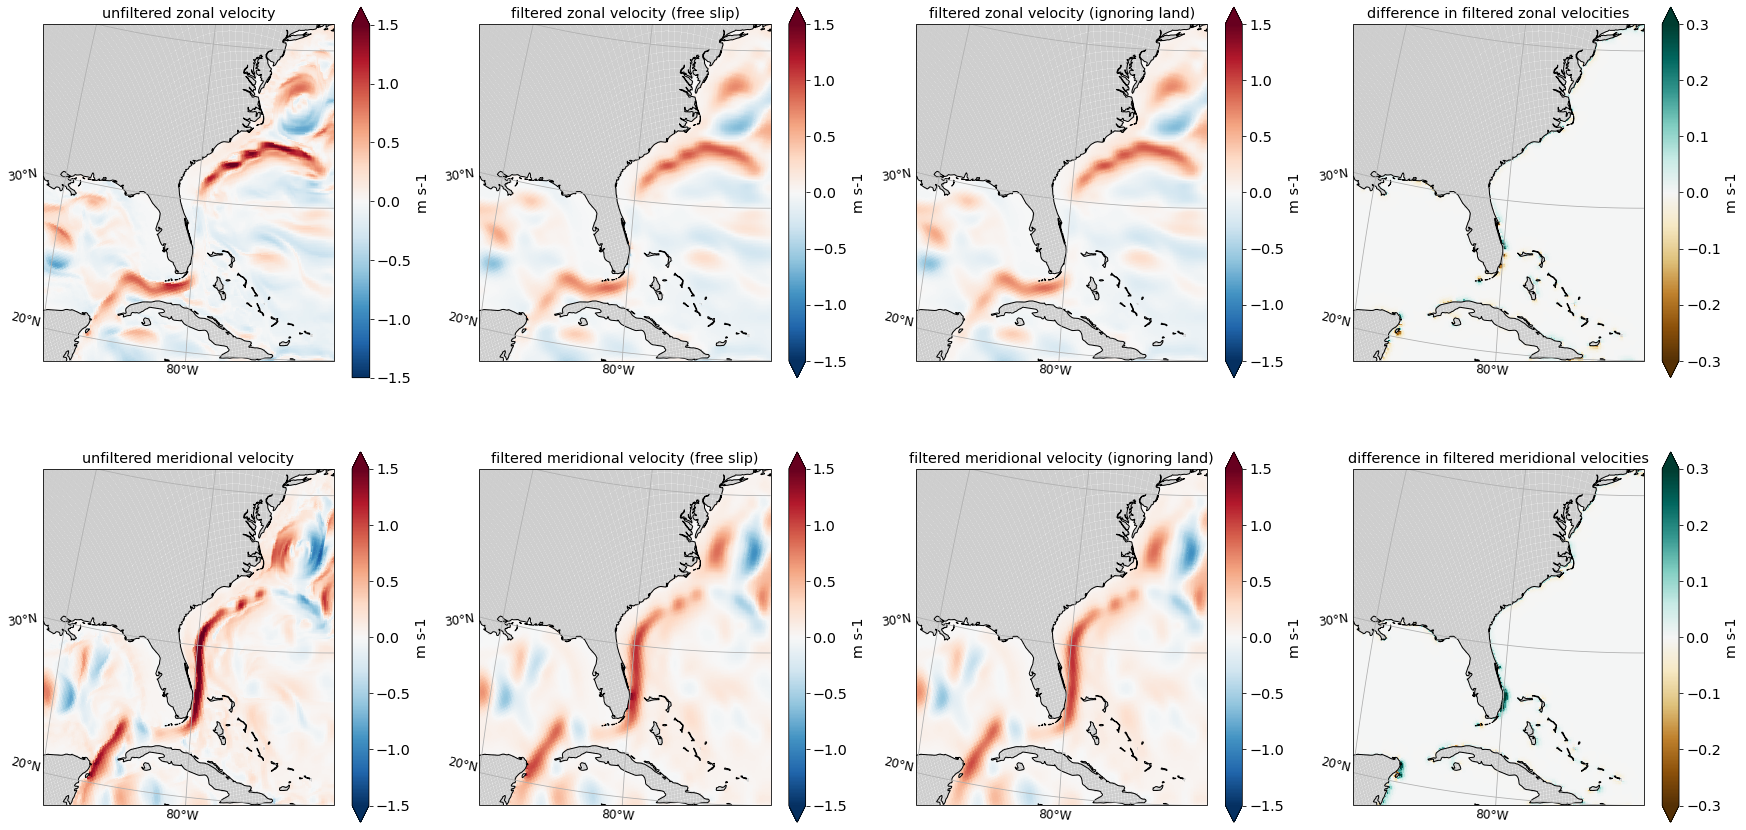

In [272]:
tmpu = u.assign_coords({'geolat': ds_static['geolat_u'], 'geolon': ds_static['geolon_u']})
tmpv = v.assign_coords({'geolat': ds_static['geolat_v'], 'geolon': ds_static['geolon_v']})
tmpu_filtered = ds_tmp.u_filtered.assign_coords({'geolat': ds_static['geolat_u'], 'geolon': ds_static['geolon_u']})
tmpv_filtered = ds_tmp.v_filtered.assign_coords({'geolat': ds_static['geolat_v'], 'geolon': ds_static['geolon_v']})
tmpu_filtered_unaware = ds_tmp.u_filtered_unaware.assign_coords({'geolat': ds_static['geolat_u'], 'geolon': ds_static['geolon_u']})
tmpv_filtered_unaware = ds_tmp.v_filtered_unaware.assign_coords({'geolat': ds_static['geolat_v'], 'geolon': ds_static['geolon_v']})

central_lon = -70
central_lat = 40
vmax = 1.5

fig,axs = plt.subplots(2,4,figsize=(30,15),subplot_kw={'projection':ccrs.Orthographic(central_lon, central_lat)})

tmpu.where(ds_static.wet_u).plot(ax=axs[0,0], x='geolon', y='geolat', vmin=-vmax, vmax=vmax, cmap=cmap, cbar_kwargs={'label': 'm s-1'},
                transform=ccrs.PlateCarree())
tmpv.where(ds_static.wet_v).plot(ax=axs[1,0], x='geolon', y='geolat', vmin=-vmax, vmax=vmax, cmap=cmap, cbar_kwargs={'label': 'm s-1'},
                transform=ccrs.PlateCarree())
tmpu_filtered.where(ds_static.wet_u).plot(ax=axs[0,1], x='geolon', y='geolat', vmin=-vmax, vmax=vmax, cmap=cmap, cbar_kwargs={'label': 'm s-1'},
                transform=ccrs.PlateCarree())
tmpv_filtered.where(ds_static.wet_v).plot(ax=axs[1,1], x='geolon', y='geolat', vmin=-vmax, vmax=vmax, cmap=cmap, cbar_kwargs={'label': 'm s-1'},
                transform=ccrs.PlateCarree())
tmpu_filtered_unaware.where(ds_static.wet_u).plot(ax=axs[0,2], x='geolon', y='geolat', vmin=-vmax, vmax=vmax, cmap=cmap, cbar_kwargs={'label': 'm s-1'},
                transform=ccrs.PlateCarree())
tmpv_filtered_unaware.where(ds_static.wet_v).plot(ax=axs[1,2], x='geolon', y='geolat', vmin=-vmax, vmax=vmax, cmap=cmap, cbar_kwargs={'label': 'm s-1'},
                transform=ccrs.PlateCarree())
(tmpu_filtered - tmpu_filtered_unaware).where(ds_static.wet_u).plot(ax=axs[0,3], x='geolon', y='geolat', vmin=-0.3, vmax=0.3, cmap=cmap2, cbar_kwargs={'label': 'm s-1'},
                transform=ccrs.PlateCarree())
(tmpv_filtered - tmpv_filtered_unaware).where(ds_static.wet_v).plot(ax=axs[1,3], x='geolon', y='geolat', vmin=-0.3, vmax=0.3, cmap=cmap2, cbar_kwargs={'label': 'm s-1'},
                transform=ccrs.PlateCarree())

for ax in axs.flatten():
    ax.coastlines()
    ax.set_extent([-90, -70, 20, 40], crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True)
    gl.xlocator = mticker.FixedLocator([-90,-80,-70])
    gl.ylocator = mticker.FixedLocator([20,30,40,50])
    gl.top_labels = False
    gl.right_labels = False

   
axs[0,0].set(title='unfiltered zonal velocity')
axs[0,1].set(title='filtered zonal velocity (free slip)')
axs[0,2].set(title='filtered zonal velocity (ignoring land)')
axs[0,3].set(title='difference in filtered zonal velocities')
axs[1,0].set(title='unfiltered meridional velocity')
axs[1,1].set(title='filtered meridional velocity (free slip)')
axs[1,2].set(title='filtered meridional velocity (ignoring land)')
axs[1,3].set(title='difference in filtered meridional velocities')

plt.savefig('figures/viscosity_filter_1000km.png',dpi=400,bbox_inches='tight',pad_inches=0) 